## Siamese Network on Micro-Expression Data
### Import all necessary packages

In [1]:
import sys
sys.path.append('/home/adrikamukherjee/venv/lib/python3.6/site-packages')

In [ ]:
#basic imports
import glob
import IPython
from random import randint

#data processing
import librosa
import numpy as np
import pandas as pd
#modelling
from sklearn.model_selection import train_test_split

from keras import backend as K
from keras.layers import Activation
from keras.layers import Input, Lambda, Dense, Dropout, Flatten
from keras.models import Model
from keras.optimizers import RMSprop
import os

### Store data from three folders each containing Truthful ,Deceptive(half of decevtive videos), Sub_Deceptive(other half of decevtive videos) files in a list

"list_dir" contains path of the three folders  

These folders have .csv files for each video containing the micro-expression features extracted using open face

mean vector from each file is calculated

In [5]:
list_dir=["/home/adrikamukherjee/Mexp_Truthful",
          "/home/adrikamukherjee/Mexp_Deceptive",
          "/home/adrikamukherjee/Mexp_Sub_Deceptive"]

Mexp_Truthful = []
Mexp_Sub_Deceptive = []
Mexp_Deceptive = []

max=0
for dir in list_dir:
    for file in glob.glob(os.path.join(dir, '*.csv')):
        ind=pd.DataFrame()
        if 'Mexp_Truthful' in file:
            ind=pd.read_csv(file)
            ind.drop(['frame', 'Unnamed: 0', 'label',' face_id',' timestamp', ' confidence', ' success'], axis = 1, inplace = True)
            ind=ind.mean(axis=0)
            ind=pd.Series.tolist(ind)
            Mexp_Truthful.append(ind)
        if 'Mexp_Deceptive' in file:
             ind=pd.read_csv(file)
             ind.drop(['frame', 'Unnamed: 0', 'label',' face_id',' timestamp', ' confidence', ' success'], axis = 1, inplace = True)
             ind=ind.mean(axis=0)
             ind=pd.Series.tolist(ind)
             Mexp_Deceptive.append(ind)
        if 'Mexp_Sub_Deceptive' in file:
             ind=pd.read_csv(file)
             ind.drop(['frame', 'Unnamed: 0', 'label',' face_id',' timestamp', ' confidence', ' success'], axis = 1, inplace = True)
             ind=ind.mean(axis=0)
             ind=pd.Series.tolist(ind)
             Mexp_Sub_Deceptive.append(ind)

print(len(Mexp_Truthful))
print(len(Mexp_Deceptive))
print(len(Mexp_Sub_Deceptive))        

358
149
149


### "get_training_data" function is used to generate training data such that two deceptive vectors are labeled as 1; one deceptive and one truthful vector are labeled as 0.

In [8]:
def get_training_data():
    
    pairs = []
    labels = []
    
    for i in range(min(len(Mexp_Truthful),len(Mexp_Sub_Deceptive))):
        #imposite pair
        if (i % 2) == 0:
            pairs.append([(Mexp_Deceptive[randint(0,3)]),(Mexp_Truthful[i])])
            labels.append(0)
            
        #genuine pair
        else:
            pairs.append([(Mexp_Deceptive[randint(0,3)]),(Mexp_Sub_Deceptive[i])])
            labels.append(1)
        
    
    return np.array(pairs), np.array(labels)

### Calculate data and Ground truths and store in X and Y

In [9]:
X, Y = get_training_data()

### Convert Ground truth type to float 32

In [ ]:
import pandas as pd
Y=pd.Series(Y).astype('float32')
Y=Y.to_numpy()

### Split Train and Test Data

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2)

### Base Model with two simple dense layer used for feature extraction is built.

In [44]:
def build_base_network(input_shape):
    input = Input(shape=input_shape)
    #x = Flatten()(input)
    x = Dense(128, activation='relu')(input)
    #x = Dropout(0.1)(x)
    x = Dense(128, activation='relu')(x)
    #x = Dropout(0.1)(x)
    return Model(input, x)

### Next, mexp pair is fed into the base network, which will return the features:

In [45]:
input_dim = X_train.shape[2:]

mexp_a = Input(shape=input_dim)
mexp_b = Input(shape=input_dim)

In [46]:
base_network = build_base_network(input_dim)

feat_vecs_a = base_network(mexp_a)
feat_vecs_b = base_network(mexp_b)

### feat_vecs_a and feat_vecs_b are the feature vectors of mexp pair; these feature vectors is fed into  the energy function to compute a distance between them,  Euclidean distance is used as energy function:

In [47]:
def euclidean_distance(vects):
    x, y = vects
    return K.sqrt(K.sum(K.square(x - y), axis=1, keepdims=True))


def eucl_dist_output_shape(shapes):
    shape1, shape2 = shapes
    return (shape1[0], 1)

In [48]:
distance = Lambda(euclidean_distance, output_shape=eucl_dist_output_shape)([feat_vecs_a, feat_vecs_b])

### set the epoch length to 12 and  RMS prop is used for optimization.

In [49]:
epochs = 12
rms = RMSprop()

In [50]:
model = Model(inputs=[mexp_a, mexp_b], outputs=distance)

### distance based Contrastive loss is defined

In [51]:
def contrastive_loss(y_true, y_pred):
    margin = 1
    return K.mean(y_true * K.square(y_pred) + (1 - y_true) * K.square(K.maximum(margin - y_pred, 0)))

### Compiling model

In [52]:
model.compile(loss=contrastive_loss, optimizer=rms)

### Train and Test data is seperated

Each mexp_x (where x={1,2,3,4}) vector has one video(either deceptive or truthful).mexp_1 and mexp_2 is used for training. One video from each list is fed into the final model. Similarly, mexp_3 and mexp_4 is used for testing.

In [53]:
mexp_1 = X_train[:, 0]
mexp_2 = X_train[:, 1]
mexp_3 = X_test[:, 0]
mexp_4 = X_test[:, 1]

In [ ]:
history=model.fit([mexp_1, mexp_2], y_train, validation_data=[[mexp_3, mexp_4], y_test],
          batch_size=128, verbose=2, nb_epoch=epochs)

### Predict on Test Data

In [56]:
y_pred = model.predict([mexp_3, mexp_4])
y_pred

array([[ 50.35117  ],
       [ 92.07148  ],
       [ 21.071135 ],
       [ 65.38318  ],
       [ 57.151657 ],
       [ 35.081448 ],
       [ 31.337528 ],
       [ 28.368048 ],
       [107.368065 ],
       [ 51.288666 ],
       [ 16.562193 ],
       [ 90.649254 ],
       [ 51.93757  ],
       [ 32.571712 ],
       [ 50.74991  ],
       [  4.7684007],
       [ 28.299114 ],
       [ 28.61923  ],
       [ 43.66343  ],
       [ 18.464552 ],
       [ 45.885067 ],
       [ 50.459084 ],
       [ 47.64403  ],
       [ 65.12779  ],
       [127.41618  ],
       [ 56.64179  ],
       [ 40.86855  ],
       [ 19.880322 ],
       [ 38.41249  ],
       [ 63.58576  ]], dtype=float32)

### Display Confusion Matrix

In [74]:
import sklearn
from sklearn.preprocessing import label_binarize
y_true = label_binarize(y_test, classes = [0, 1]) # y_test --> You get it from train_test_split

y_pred = model.predict([mexp_3, mexp_4])
y_pred_det = label_binarize(pd.Series(y_pred[:, 0]).apply(lambda y: 0 if y<50 else 1), classes = [0, 1])

conf = sklearn.metrics.confusion_matrix
conf = sklearn.metrics.confusion_matrix
conf(y_true, y_pred_det)

array([[12,  8],
       [ 4,  6]])

### Calculate Precision and Recall and other Metrics

In [75]:
conf_res = conf(y_true, y_pred_det)
print("Precision in predicting two deceptive videos: ", conf_res[1][1]/(conf_res[1][1]+conf_res[0][1]))
print("Recall in in predicting two deceptive videos: ", conf_res[1][1]/(conf_res[1][1]+conf_res[1][0]))

Precision in predicting two deceptive videos:  0.42857142857142855
Recall in in predicting two deceptive videos:  0.6


In [76]:
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix,cohen_kappa_score,roc_auc_score, accuracy_score


# Print f1, precision, and recall scores
prec = precision_score(y_true, y_pred_det , average="macro")
rec = recall_score(y_true, y_pred_det , average="macro")
fsc= f1_score(y_true, y_pred_det , average="macro")
# kappa
kappa = cohen_kappa_score(y_true, y_pred_det)
print('Cohens kappa: %f' % kappa)
# ROC AUC
auc = roc_auc_score(y_true, y_pred_det)
print('ROC AUC: %f' % auc)
accu = accuracy_score(y_true, y_pred_det)
print('Precision: %f' % prec)
print('Recall: %f' % rec)
print('Accuracy: %f' % accu)
print('fsc: %f' % fsc)

Cohens kappa: 0.181818
ROC AUC: 0.600000
Precision: 0.589286
Recall: 0.600000
Accuracy: 0.600000
fsc: 0.583333


### Plot ROC Curve

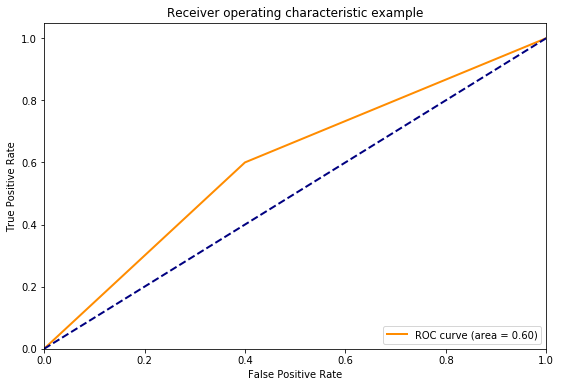

In [67]:
from sklearn.metrics import roc_curve, auc
fpr = dict()
tpr = dict()
roc_auc = dict()
i=0
fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_pred_det[:, i])
roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(9, 6))
lw = 2
plt.plot(fpr[0], tpr[0], color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[0])
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()